In [1]:
import os

In [2]:
import numpy as np

In [3]:
from ase.build import bulk
from ase.io import write
from pwtools import io

In [4]:
from ase.atoms import Atoms

In [5]:
import matplotlib.pyplot as plt

In [6]:
from pyiron_base import GenericJob, Project

# Quantum Espresso Interface

In [7]:
class QuantumEspressoJob(GenericJob):
    def __init__(self, project, job_name):
        super(QuantumEspressoJob, self).__init__(project, job_name)
        self.structure = None 
        self.input_data = {'calculation': 'scf'}
        self.executable = "mpirun -np 1 pw.x -in espresso.pwi > espresso.pwo"
        self.pseudopotentials = {}
        self.kpoints = (3, 3, 3)

    def calc_minimize(self):
        self.input_data = {'calculation': 'vc-relax', 'cell_dofree': 'ibrav'}

    def write_input(self):
        file = os.path.join(self.working_directory, 'espresso.pwi') 
        write(
            file, 
            self.structure, 
            Crystal=True, 
            kpts=self.kpoints, 
            input_data=self.input_data, 
            pseudopotentials=self.pseudopotentials,
            tstress=True, 
            tprnfor=True
        )

    def collect_output(self):
        file = os.path.join(self.working_directory, 'espresso.pwo') 
        if self.input_data["calculation"] == 'vc-relax':
            output = io.read_pw_md(file)
        else:
            output = io.read_pw_scf(file)
        with self._hdf5.open("output") as hdf5_output:
            hdf5_output["energy_tot"] = output.etot
            hdf5_output["positions"] = output.coords
            hdf5_output["cell"] = output.cell
            hdf5_output["forces"] = output.forces
            hdf5_output["volume"] = output.volume

    def get_structure(self, ind=-1):
        structure_out = self.structure.copy()
        structure_out.set_cell(self["output/cell"][-1])
        structure_out.set_positions(self["output/positions"][-1])
        return structure_out
        
    def to_hdf(self, hdf=None, group_name=None):
        super(QuantumEspressoJob, self).to_hdf(hdf=hdf, group_name=group_name)
        with self._hdf5.open("input") as hdf5_input:
            if self.structure is not None:
                hdf5_input["structure"] = self.structure.todict()
            hdf5_input["data"] = self.input_data
            hdf5_input["kpoints"] = self.kpoints
            if len(self.pseudopotentials) > 0:
                hdf5_input["potential"] = self.pseudopotentials

    def from_hdf(self, hdf=None, group_name=None):
        super(QuantumEspressoJob, self).from_hdf(hdf=hdf, group_name=group_name)
        with self._hdf5.open("input") as hdf5_input:
            if "structure" in hdf5_input.list_nodes():
                structure_dict = hdf5_input["structure"]
                self.structure = Atoms(
                    positions=structure_dict['positions'],
                    numbers=structure_dict['positions'],
                    cell=structure_dict['cell'],
                    pbc=structure_dict['pbc'],
                )
            if "potential" in hdf5_input.list_nodes():
                self.pseudopotentials = hdf5_input["potential"]
            self.input_data = hdf5_input["data"]
            self.kpoints = hdf5_input["kpoints"]

# Workflow

In [8]:
pr = Project("test")
pr.remove_jobs(recursive=True, silently=True)

## Structure Optimization

In [9]:
structure = bulk('Al', a=4.15, cubic=True)

In [10]:
job_relax = pr.create_job(job_type=QuantumEspressoJob, job_name="job_relax")
job_relax.structure = structure
job_relax.calc_minimize()
job_relax.pseudopotentials = {"Al": "Al.pbe-n-kjpaw_psl.1.0.0.UPF"}
job_relax.run()

The job job_relax was saved and received the ID: job_relax


In [11]:
job_relax["output/positions"][-1]

array([[0.        , 0.        , 0.        ],
       [0.        , 2.06947316, 2.06947316],
       [2.06947316, 0.        , 2.06947316],
       [2.06947316, 2.06947316, 0.        ]])

In [12]:
structure_opt = job_relax.get_structure()
structure_opt

Atoms(symbols='Al4', pbc=True, cell=[4.138946316999999, 4.138946316999999, 4.138946316999999])

## Energy Volume Curve

In [13]:
energy_lst, volume_lst = [], []
for i, strain in enumerate(np.linspace(0.9, 1.1, 5)):
    structure_strain = structure_opt.copy()
    structure_strain = structure.copy()
    structure_strain.set_cell(structure_strain.cell * strain**(1/3), scale_atoms=True)
    job_strain = pr.create_job(job_type=QuantumEspressoJob, job_name="job_strain_" + str(i))
    job_strain.structure = structure_strain
    job_strain.pseudopotentials = {"Al": "Al.pbe-n-kjpaw_psl.1.0.0.UPF"}
    job_strain.run()
    energy_lst.append(job_strain["output/energy_tot"])
    volume_lst.append(job_strain["output/volume"])

The job job_strain_0 was saved and received the ID: job_strain_0
The job job_strain_1 was saved and received the ID: job_strain_1
The job job_strain_2 was saved and received the ID: job_strain_2
The job job_strain_3 was saved and received the ID: job_strain_3
The job job_strain_4 was saved and received the ID: job_strain_4


# Result

Text(0, 0.5, 'Energy')

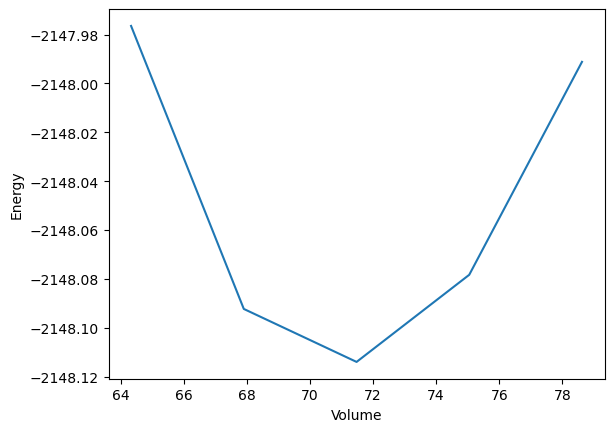

In [14]:
plt.plot(volume_lst, energy_lst)
plt.xlabel("Volume")
plt.ylabel("Energy")